## Section E. Bias-Variance Analysis

In this section, you conduct a bias-variance study on the ridge regression that
you have developed in Section D . This task assesses your analytical skills, and is
based on Chapter 6 of Module 2. You basically recreate Figure 2.6.3 of Module 2
using your implementation of Ridge regression (with SGD) from Section D .

### Question 7 [Bias-Variance for Ridge Regression, 25 Marks]

In [3]:
# Load the libraries for wrangling and plotting data
library(ggplot2) 
library(reshape2)

In [4]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

In [5]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

In [6]:
##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   grad = (- (y_true-y_pred) %*% x ) + lambda %*% W_prev
   return(W_prev - eta %*% grad)
}

In [7]:
# Function to return the optimum values of W
SGD_q7 <- function(lambda=0, train_x, train_y) {
 
   ##### SGD Trainng
   max_epoch = 20
   epsilon = .001
   eta = .01
    
   # Get the weights using the training dataset
   train_res = sgd_train(train_x, train_y, lambda, eta, epsilon, max_epoch)

   # Return the weights vector
   return(train_res$W)

}

1. Load Task2B_train.csv and Task2B_test.csv sets.

In [8]:
## reading the data
dtrain = read_data("Task2B_train.csv", TRUE)
dtest = read_data("Task2B_test.csv", TRUE)

# Length of train set
N <- nrow(dtrain$x)

2. Sample 50 sets from the provided training set, each of which having 100
randomly selected data points (with replacement).

In [9]:
# Create 50 datasets of size 100
D = 100  # the number of samples in each selected dataset
L = 50 # number of datasets 

# Boot function as implemented in the Q3
boot <- function (original.size=100, sample.size=original.size, times=100){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}

# indices of 100 samples of 50 datasets
boot.indx <- boot(N, 100, 50)

3. For each lambda in {0, 0.2, 0.4, 0.6, ..., 5} do:
<br>
a. Build 50 regression models using the sampled sets
<br>
b. Based on the predictions of these models on the test set, calculate
the (average) test error, variance, (bias) 2 , and variance + (bias) 2 .
Plot the (average) test error, variance, (bias) 2 , and variance + (bias) 2
versus log lambda, and include it in your Jupyter Notebook file for
Question 7.

In [10]:
# Sequence of lambda {0, 0.2, 0.4, 0.6, ..., 5}
lambda <- seq(from = 0, to = 5, by = 0.2)

M <- length(lambda)

Get the bias square, variance and average test error for each value of lambda and store them in a vector.

In [11]:
# Store the average test errors for 26 lambda values
avg_test_error_c <- c()

# Store the variance for 26 lambda values
variance_c <- c()

# Store the bias square for 26 lambda values
bias2_c <- c()

y_true <- dtest$y

for (each in lambda){ # for each lambda
    
    # Dataframe to store all the predicted values of "y" for each lambda
    y <- data.frame(matrix(0,nrow=L, ncol=N))
    names(y) <- c(paste('y',1:(N), sep=''))
    
    # dataframe for variance
    y_minus_ybar <- data.frame(matrix(0,nrow=L, ncol=N))
    names(y) <- c(paste('y',1:(N), sep=''))
    
    # Vector to store the error for every dataset (L)
    error_l <- c()
    
    for (l in 1:L){ # for each value of lambda...

        train <- dtrain$x # train lables
        test<- dtrain$y # output for train labels

        indx <- boot.indx[l,]

        # Get Ws using SGD
        output <- SGD_q7(lambda=each, train[indx,], test[indx,])

        # take the last values (optimum) of W 
        W = output[dim(output)[1],]
        
        # Predicted output
        y_predicted <- predict_func(dtest$x, W)     
        
        #  square error of each data
        error2 <- (y_predicted - y_true)^2
        
        # Vector to store the mean square errors for all the datasets
        error_l <- c(error_l, mean(error2))

        y[l,] <- y_predicted
    }   

    # Set the lambda values. Required for melting "y"
    y['L'] = 1:L

    # Y_BAR. Mean of y for each dataset L.Ignore the mean of Lambda
    y_bar <- colMeans(y[, -(N+1)], na.rm = FALSE, dims = 1)

    # AVERAGE TEST ERROR
    avg_test_error <- mean(error_l)
    avg_test_error_c <- c(avg_test_error_c, avg_test_error)

    # BIAS SQUARE
    bias2 <- mean((y_bar - y_true)^2)
    bias2_c <- c(bias2_c, bias2)

    ## Get the y labels corresponding to each y-output
    y_labels <- names(y)
    l <- head(1:length(y_labels), -1)
    y_labels <- y_labels[l]


    # Melt the y dataframe to get the value for each label for each L
    y.m <- melt(y, id = "L")
    names(y.m) <- c('L', 'Label', 'Value')

    # Variance
    for (lab in y_labels){    

        # Just get the df where "Label" == lab
        x <- y.m[y.m['Label'] == lab,]

        # subtract average error from every y of the df
        sub_ybar <- x["Value"] - y_bar[lab]
        y_minus_ybar[, lab] = sub_ybar^2

    }
    
    # (1/L)*Sum(y-y_bar)^2
    y_minus_ybar_L <- colMeans(y_minus_ybar, na.rm = FALSE, dims = 1)
    
     # (1/N)sum((1/L)*Sum(y-y_bar)^2)
    variance <- mean(y_minus_ybar_L)
    
    # Combine all the variances
    variance_c <- c(variance_c, variance)

    
}



In [12]:
# create empty dataframe to store 'lambda', 'error', 'variance', 'bias2' and 'bias2variance'
output <- data.frame(matrix(0,nrow=M, ncol=5))
                
names(output) <- c('lambda', 'error', 'variance', 'bias2', 'bias2variance')

output$lambda <- lambda

Store 'lambda', 'error', 'variance', 'bias2' and 'bias2variance' in the dataframe to analyze the results.

In [13]:
# Store all the combined vectors
output$error <- avg_test_error_c
output$variance <- variance_c
output$bias2 <- bias2_c
output$bias2variance <- variance_c + bias2_c

head(output)

lambda,error,variance,bias2,bias2variance
0.0,0.01779494,0.0009390678,0.01591681,0.01685587
0.2,0.02042369,0.0004509838,0.01952172,0.01997270
0.4,0.02766430,0.0004480702,0.02676816,0.02721623
0.6,0.03706988,0.0005927057,0.03588447,0.03647718
0.8,0.04962182,0.0005386246,0.04854457,0.04908320
1.0,0.06433390,0.0012369661,0.06185997,0.06309694


Perform bias-variance decomposition and verify the result average error = (bias^2 + variance) using visualization.

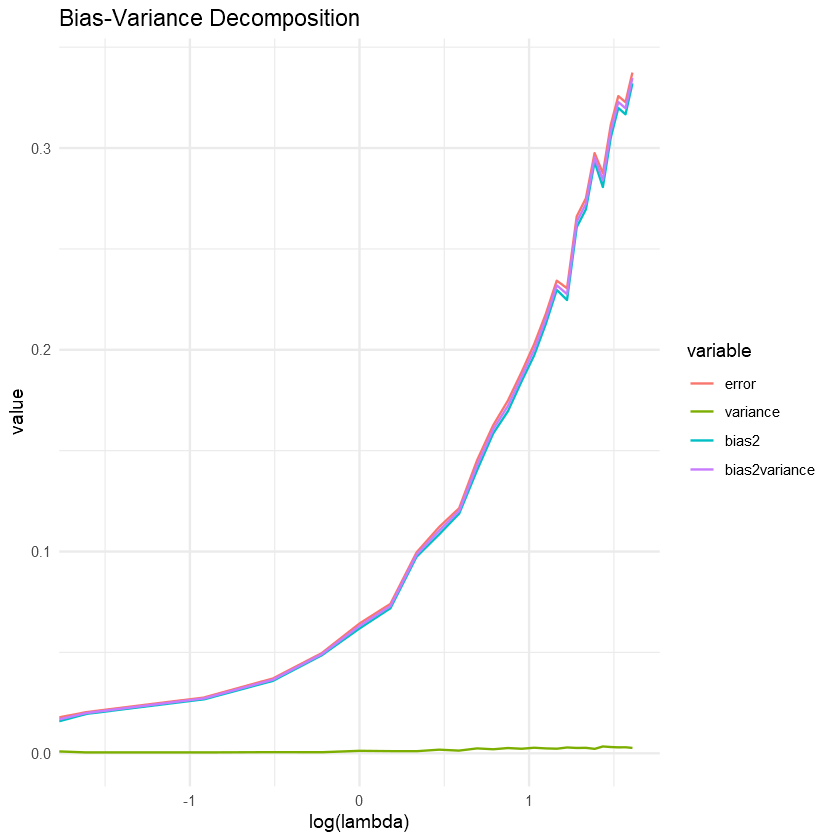

In [14]:
# wrangle for visualization
output.m <- melt(output, id='lambda')

# Plot visualization
ggplot(data=output.m, aes(x=log(lambda), y=value, color=variable)) + geom_line() + 
        labs(title='Bias-Variance Decomposition') +  theme_minimal()

4. Based on your plot in the previous part (Part III), what’s the best value for lambda?

**Answer**
* The above graph showcases the relationship between average test error, square of biase and variance. The graph plots the values of average error, bias square and variance against the changing value of lambda {0,0.2,...,5.0}.
* From the above plot, it can be verified that average error = (bias)^2 + variance
* Since variance is almost constant for all the values of lambda, the least bias is observed for lambda = 0. However, the value is lambda in the range 0 to 0.8 yield very close results. Thus the optimum value of lambda lies between 0 to 0.8.